<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Analyse-d'autocorrélation" data-toc-modified-id="Analyse-d'autocorrélation-1">Analyse d'autocorrélation</a></span></li></ul></div>

In [20]:
from IPython.display import display
from math import ceil, sqrt
import numpy as np 
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import statsmodels.api as sm
import joblib
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller

# colors generator
from itertools import cycle
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
# Preprocessing
from sklearn.preprocessing import MinMaxScaler
# # Algorithms
# from sklearn.cluster import KMeans
# from sklearn.metrics import pairwise_distances_argmin_min
# from sklearn.decomposition import PCA
# from tslearn.barycenters import dtw_barycenter_averaging
# Modeling
from statsmodels.tsa.stattools import acf
# from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
from pmdarima.arima.utils import nsdiffs
from pmdarima.arima.utils import ndiffs

from sklearn.model_selection import ParameterGrid
#metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

# assert reproducibility
import random
random.seed(7)
np.random.seed(7)
print("setup complete")

def pretty_df(data_f):
    df = data_f.copy()
    df["Series"] = df.index
    cols = df.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    df = df[cols]
    return df.style.hide_index().set_properties(
    **{'color': 'black  !important',
       'border': '1px black solid !important', "text-align": "left"}
).set_table_styles([{
    'selector': 'th',
    'props': [('border', '1px black solid !important'), ("text-align", "center")]
}]).set_properties(
    subset=[cols[0]], 
    **{'font-weight': 'bold'}
)

setup complete


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def remove_axes(n_used_axes, all_axs):
    if n_used_axes%2 :
        all_axs = all_axs.flatten()
        size = len(all_axs)
        for useless_ax in all_axs.flatten()[-(size - n_used_axes):]:
            useless_ax.axis('off')

In [4]:
def choose_d(l):
    return list(sorted(l))[1]
def Oui_non(x): 
    return "Oui" if x else "Non"
def test_all(y):
    y = y.dropna()
    n_ch = nsdiffs(remove_trend(y)["serie"].dropna(), m=12, max_D=12, test='ch')
    n_ocsb = nsdiffs(remove_trend(y)["serie"].dropna(), m=12, max_D=12, test='ocsb')
    n_adf = ndiffs(y, test='adf')
    n_kpss = ndiffs(y, test='kpss')
    n_pp = ndiffs(y, test='pp')
    return (Oui_non(n_ch), Oui_non(n_ocsb), max(n_ch, n_ocsb), Oui_non(n_adf), \
            Oui_non(n_kpss), Oui_non(n_pp), choose_d((n_adf, n_kpss, n_pp)))
def multiple_test_all(df):
    res = pd.DataFrame(df.columns, columns=["Series"])
    res[1], res[2], res[3], res[4], res[5], res[6], res[7] = [[test_all(df[i])[j]\
                                               for i in df.columns] for j in range(7)]
    res=res.set_index("Series")
    res.columns = ["Canova-Hansen", "OCSB", "Seasonality Order", "ADF", "KPSS", "PP", "differencing order"]
    return res

In [5]:
def remove_trend(y):
    n_adf = ndiffs(y, test='adf')
    n_kpss = ndiffs(y, test='kpss')
    n_pp = ndiffs(y, test='pp')
    n_diff = choose_d((n_adf, n_kpss, n_pp))
    for i in range(n_diff):
        y = y.diff(1)
    return {"serie" : y, "n_diff" : n_diff}
def stationnarise(y):
    y ,n_diff = remove_trend(y).values()
    y = y.dropna()
    n_ch = nsdiffs(y, m=12, max_D=12, test='ch')
    n_ocsb = nsdiffs(y, m=12, max_D=12, test='ocsb')
    n_sdiff=max(n_ch, n_ocsb)
    for i in range(n_sdiff):
        y = y.diff(12)
    return {"serie" : y, "n_diff" : n_diff, "n_sdiff" : n_sdiff}

In [6]:
def series_from_summary(summary):
    return pd.DataFrame([dic['serie'] for dic in summary.values()]).T

In [7]:
def excess_short(forecast, actual):
    epsilon = forecast - actual
    mape = np.mean(np.abs(epsilon)/np.abs(actual))
    exces_mask = epsilon>0
    short_mask = epsilon<0
    mape_exces = np.sum(np.abs(forecast[exces_mask] - actual[exces_mask])/np.abs(actual[exces_mask]))/len(forecast)
    mape_short = np.sum(np.abs(forecast[short_mask] - actual[short_mask])/np.abs(actual[short_mask]))/len(forecast)
    return 100*mape_exces/mape, 100*mape_short/mape

In [8]:
def forecast_accuracy(forecast, actual):
    assert len(forecast) == len(actual)
    mape = mean_absolute_percentage_error(actual, forecast)*100
    mae = mean_absolute_error(actual, forecast)   # MAE
    rmse = mean_squared_error(actual, forecast, squared=True)  # RMSE
    mape_exces, mape_short = excess_short(forecast, actual)
    return pd.Series({'mape':mape, 'mae': mae, 'rmse':rmse, 'mape_exces':mape_exces,'mape_short':mape_short})

In [9]:
sales_s = pd.read_pickle("sales_s.pkl")
# sales_s = sales_s[['P_6', 'P_47','P_22', 'P_24', 'P_30', 'P_37', 'P_38', 'P_55', 'P_64']]
sales_s.head()

,P_6,P_22,P_24,P_30,P_37,P_38,P_47,P_55,P_64
2014-07-31,2244,10467,7204,19852,1865,3510,510,3849,1039
2014-08-31,1970,11319,7477,19164,2043,3804,524,3980,1134
2014-09-30,1877,10956,7592,17382,2188,3859,595,3787,1160
2014-10-31,1615,9822,7435,16034,2297,3823,636,3745,1180
2014-11-30,1796,10427,7434,16430,2432,3535,572,3861,1065


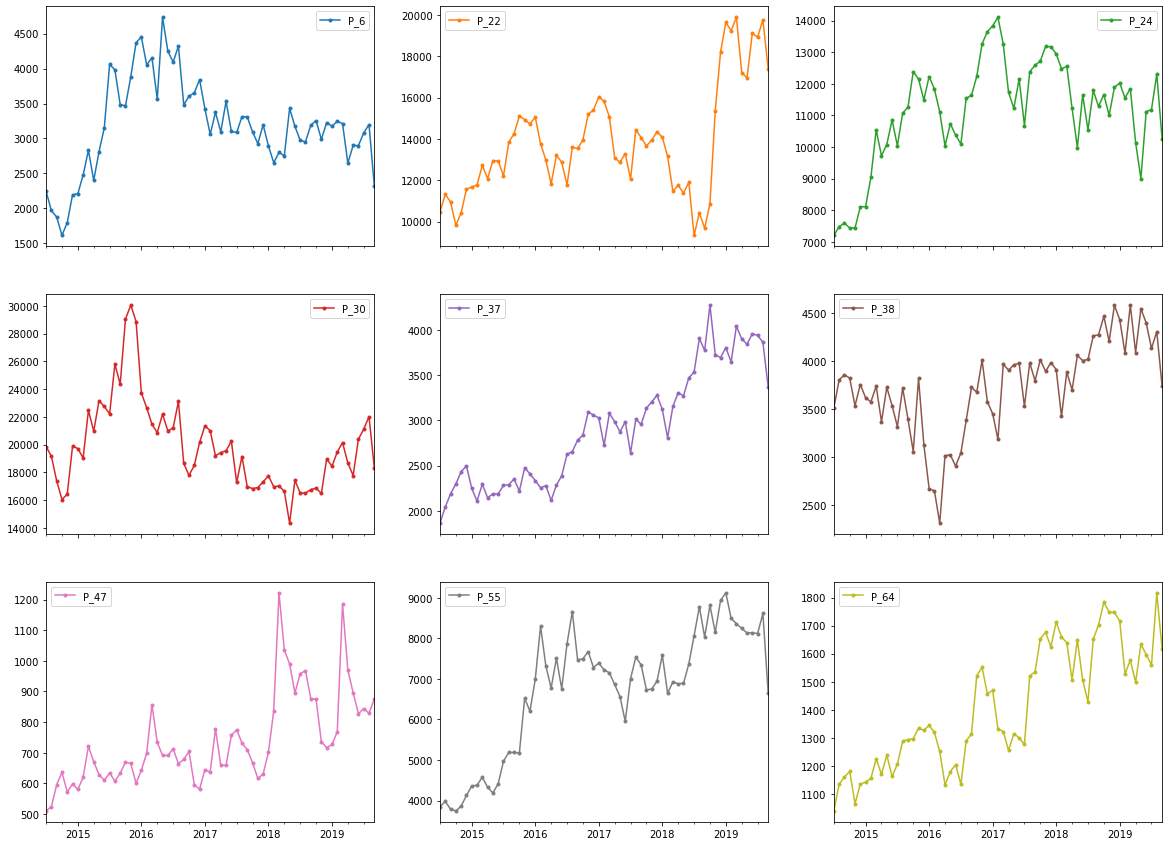

In [10]:
sales_s.plot(subplots=True,layout=(3,3),figsize=(20,15), marker='.')
plt.show()

## Analyse d'autocorrélation

\
L'analyse d'autocorrélation illustre le potentiel de prédiction des données de séries chronologiques. Les graphiques d'autocorrélation résument graphiquement la force d'une relation avec une observation dans une série chronologique avec des observations à des pas de temps antérieurs. Le coefficient de Pearson est utilisé pour mesurer l'autocorrélation. Ainsi, l'analyse suivante n'est pertinente que pour les données avec une distribution gaussienne normale.

Un tracé de l'autocorrélation d'une série chronologique par décalage est appelé la fonction d'autocorrélation (ACF). Ce graphique est parfois appelé corrélogramme ou graphique d'autocorrélation. Le graphique montre la valeur de décalage le long de l'axe des x et la corrélation sur l'axe des y entre -1 et 1. Les intervalles de confiance sont dessinés sous forme de cône. Par défaut, il est défini sur un intervalle de confiance de 95%, ce qui suggère que les valeurs de corrélation en dehors de ce code sont très probablement une corrélation.

En général, la corrélation «partielle» entre deux variables est la quantité de corrélation entre elles qui n'est pas expliquée par leurs corrélations mutuelles avec un ensemble spécifié d'autres variables. Par exemple, si nous régressons une variable Y sur d'autres variables X1, X2 et X3, la corrélation partielle entre Y et X3 est la quantité de corrélation entre Y et X3 qui n'est pas expliquée par leurs corrélations communes avec X1 et X2.

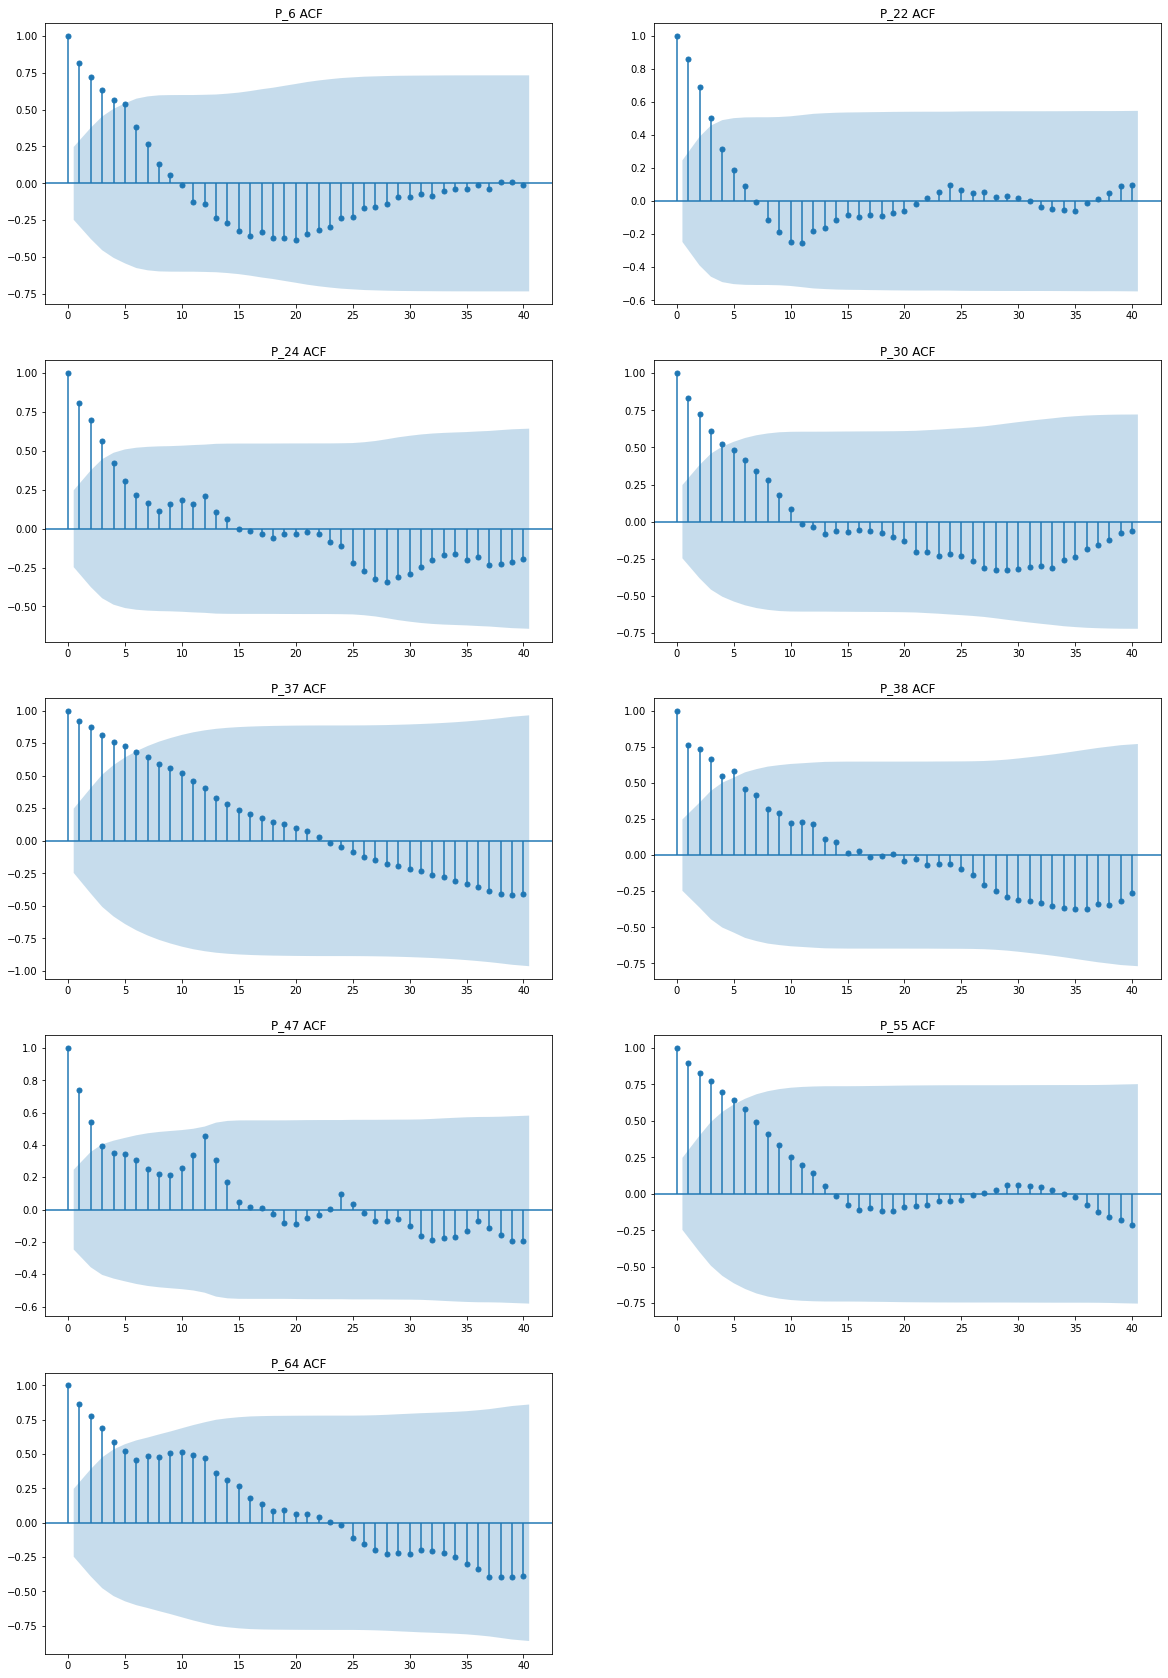

In [11]:
fig, axes = plt.subplots(5, 2, figsize=(20, 30), sharex=False)
axes[-1, -1].axis('off')
axs = axes.flatten()
alpha=.05
for i, col in enumerate(sales_s.columns):
    sm.graphics.tsa.plot_acf(sales_s[col].values.squeeze(), lags=40, ax=axs[i], title=f"{col} ACF", alpha=alpha)

D'après les correlogrames des séries temporelles ci dessus, on peut constater que la fonction d'autocorrelation se dégrade ou diminue lentement, ce qui indique la non stationnarité des séries.
De plus, dans les deux séries des produits p_47 et p_64 l'ACF montre une oscillation et des pics qui se reproduisent avec des décalages de 12 mois indicant un effet de saisonnalité.


Afin d'estimer le terme de différenciation saisonnière D, on a effectué deux tests de saisonnalité pour différents niveaux de D pour estimer le nombre de différences saisonnières nécessaires pour rendre la série chronologique stationnaire et on a sélectionné la valeur maximale de D pour laquelle la série chronologique est jugée saisonnièrement stationnaire par le test statistique.

De même, pour estimer le terme de différenciation d, on a effectué trois test statistiques de racine unitaire : Augmented Dickey Fuller (ADF), Phillips–Perron (PP) et Kwiatkowski–Phillips–Schmidt–Shin (KPSS) pour différents niveaux de d afin d'estimer le nombre de différences nécessaires pour rendre chaque série chronologique stationnaire, et on a sélectionné la valeur maximale de d pour laquelle la série temporelle est jugée stationnaire par le test statistique.

Le tableau ci dessous synthétise les résultats, chaque test de saisonnalité indique la présence ou absence d'un effet de saisonnalié, et de même pour les tests de racine unitaire, ainsi que les ordres de differenciation nécaissaires pour stationnarier la série.

In [12]:
multiple_test_all(sales_s)

,Canova-Hansen,OCSB,Seasonality Order,ADF,KPSS,PP,differencing order
Series,,,,,,,
P_6,Non,Non,0,Oui,Non,Oui,1
P_22,Non,Non,0,Oui,Oui,Oui,1
P_24,Non,Non,0,Oui,Oui,Oui,1
P_30,Non,Non,0,Oui,Oui,Oui,1
P_37,Non,Non,0,Oui,Oui,Non,1
P_38,Non,Non,0,Oui,Oui,Non,1
P_47,Non,Oui,1,Non,Oui,Non,0
P_55,Non,Non,0,Oui,Oui,Oui,1
P_64,Non,Oui,1,Non,Oui,Non,0


On a procedé par la suite à la stationnarisation des séries en appliquant la differenciation adéquate, et on a reéffectué les mêmes tests pour confirmer qu'on a atteint la stationnarité des séries.

In [13]:
stationnarisation_summary  = {key: 0 for key in sales_s.columns}
for col in sales_s.columns:
    stationnarisation_summary[col] = stationnarise(sales_s[col])
stationnaries = series_from_summary(stationnarisation_summary)

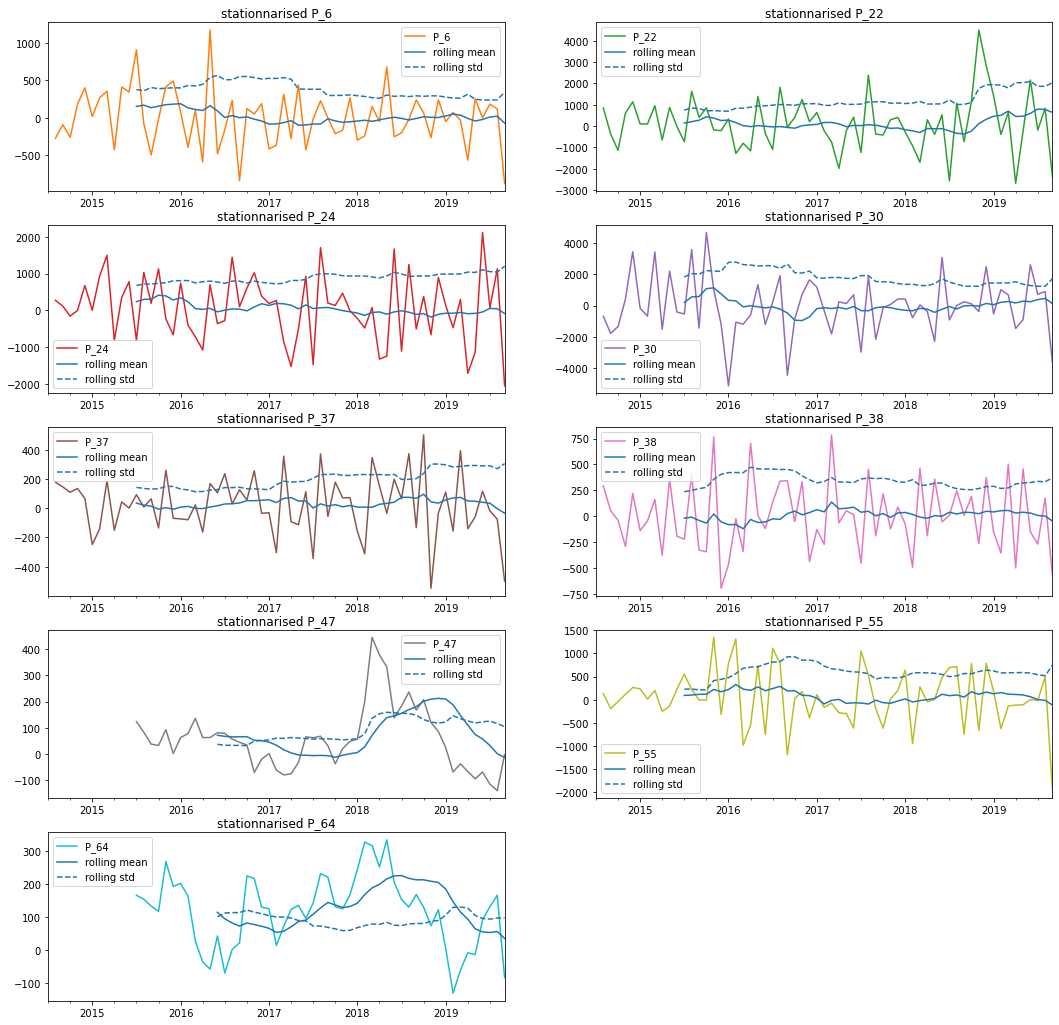

In [14]:
fig, axs = plt.subplots(5, 2, figsize=(18, 18))
remove_axes(len(sales_s.columns), axs)
axs = axs.flatten()
cols = [next(color_cycle)]*3
for i, item in enumerate(sales_s.columns):
    stationnaries[item].plot(title=f"stationnarised {item}",
                     color=next(color_cycle),
                     ax=axs[i])
    stationnaries[item].rolling(12).mean().plot(
                     color=cols[1],
                     ax=axs[i], label="rolling mean")
    stationnaries[item].rolling(12).std().plot(
                     color=cols[2],
                     ax=axs[i], linestyle='--', label="rolling std")
    axs[i].legend()

In [15]:
multiple_test_all(stationnaries)

,Canova-Hansen,OCSB,Seasonality Order,ADF,KPSS,PP,differencing order
Series,,,,,,,
P_6,Non,Non,0,Non,Non,Non,0
P_22,Non,Non,0,Non,Non,Non,0
P_24,Non,Non,0,Non,Non,Non,0
P_30,Non,Non,0,Non,Non,Non,0
P_37,Non,Non,0,Non,Non,Non,0
P_38,Non,Non,0,Non,Non,Non,0
P_47,Non,Non,0,Oui,Non,Oui,1
P_55,Non,Non,0,Non,Non,Non,0
P_64,Non,Non,0,Oui,Non,Oui,1


On peut constater la stationnarité des séries a partir des corrélogrammes ci dessous, ces derniers nous permettent aussi de déterminer l'ordre d'ARIMA, mais la détéction visuelle ne permet pas toujours d'atteindre la performance maximale, c'est pourquoi on a utilisé la fonction auto_arima qui permet d'ajuste le meilleur modèle ARIMA à une série temporelle univariée selon un critère d'information fourni (soit AIC, AICc, BIC ou HQIC). La fonction effectue une recherche (soit pas à pas, soit parallélisée) sur des ordres de modèle et saisonniers possibles dans les contraintes fournies, et sélectionne les paramètres qui minimisent la métrique donnée.

L'approche parallèle est une méthode de brute force naïve, il s'agit d'une recherche de grille (grid search) sur diverses combinaisons d'hyperparamètres. Cela prendra généralement plus de temps pour plusieurs raisons. Tout d'abord, il n'y a pas de procédure intelligente sur la façon dont les commandes de modèles sont testées ; ils sont tous testés (pas de court-circuit), ce qui peut prendre un certain temps.

L'approche par étapes (stepwise) suit la stratégie définie par Hyndman et Khandakar dans leur article de 2008, « Automatic Time Series Forecasting : The Forecast Package for R ».

Étape 1 : Essayez quatre modèles possibles pour commencer :

ARIMA(2,d,2) si m = 1 et ARIMA(2,d,2)(1,D,1) si m > 1\
ARIMA(0,d,0) si m = 1 et ARIMA(0,d,0)(0,D,0) si m > 1\
ARIMA(1,d,0) si m = 1 et ARIMA(1,d,0)(1,D,0) si m > 1\
ARIMA(0,d,1) si m = 1 et ARIMA(0,d,1)(0,D,1) si m > 1\
Le modèle avec le plus petit AIC (ou BIC, ou AICc, etc., selon les critères de minimisation) est sélectionné. C'est le "meilleur" modèle actuel.

Étape 2 : Considérez un certain nombre d'autres modèles :

Où l'un des p, q, P et Q peut varier de ±1 par rapport au meilleur modèle actuel\
Où p et q varient tous les deux de ±1 par rapport au meilleur modèle actuel\
Où P et Q varient tous les deux de ±1 par rapport au meilleur modèle actuel\
Chaque fois qu'un modèle avec un critère d'information inférieur est trouvé, il devient le nouveau meilleur modèle actuel, et la procédure est répétée jusqu'à ce qu'il ne puisse pas trouver un modèle proche du meilleur modèle actuel avec un critère d'information inférieur ou que le processus dépasse l'un des seuils d'exécution défini via arima.StepwiseContext.


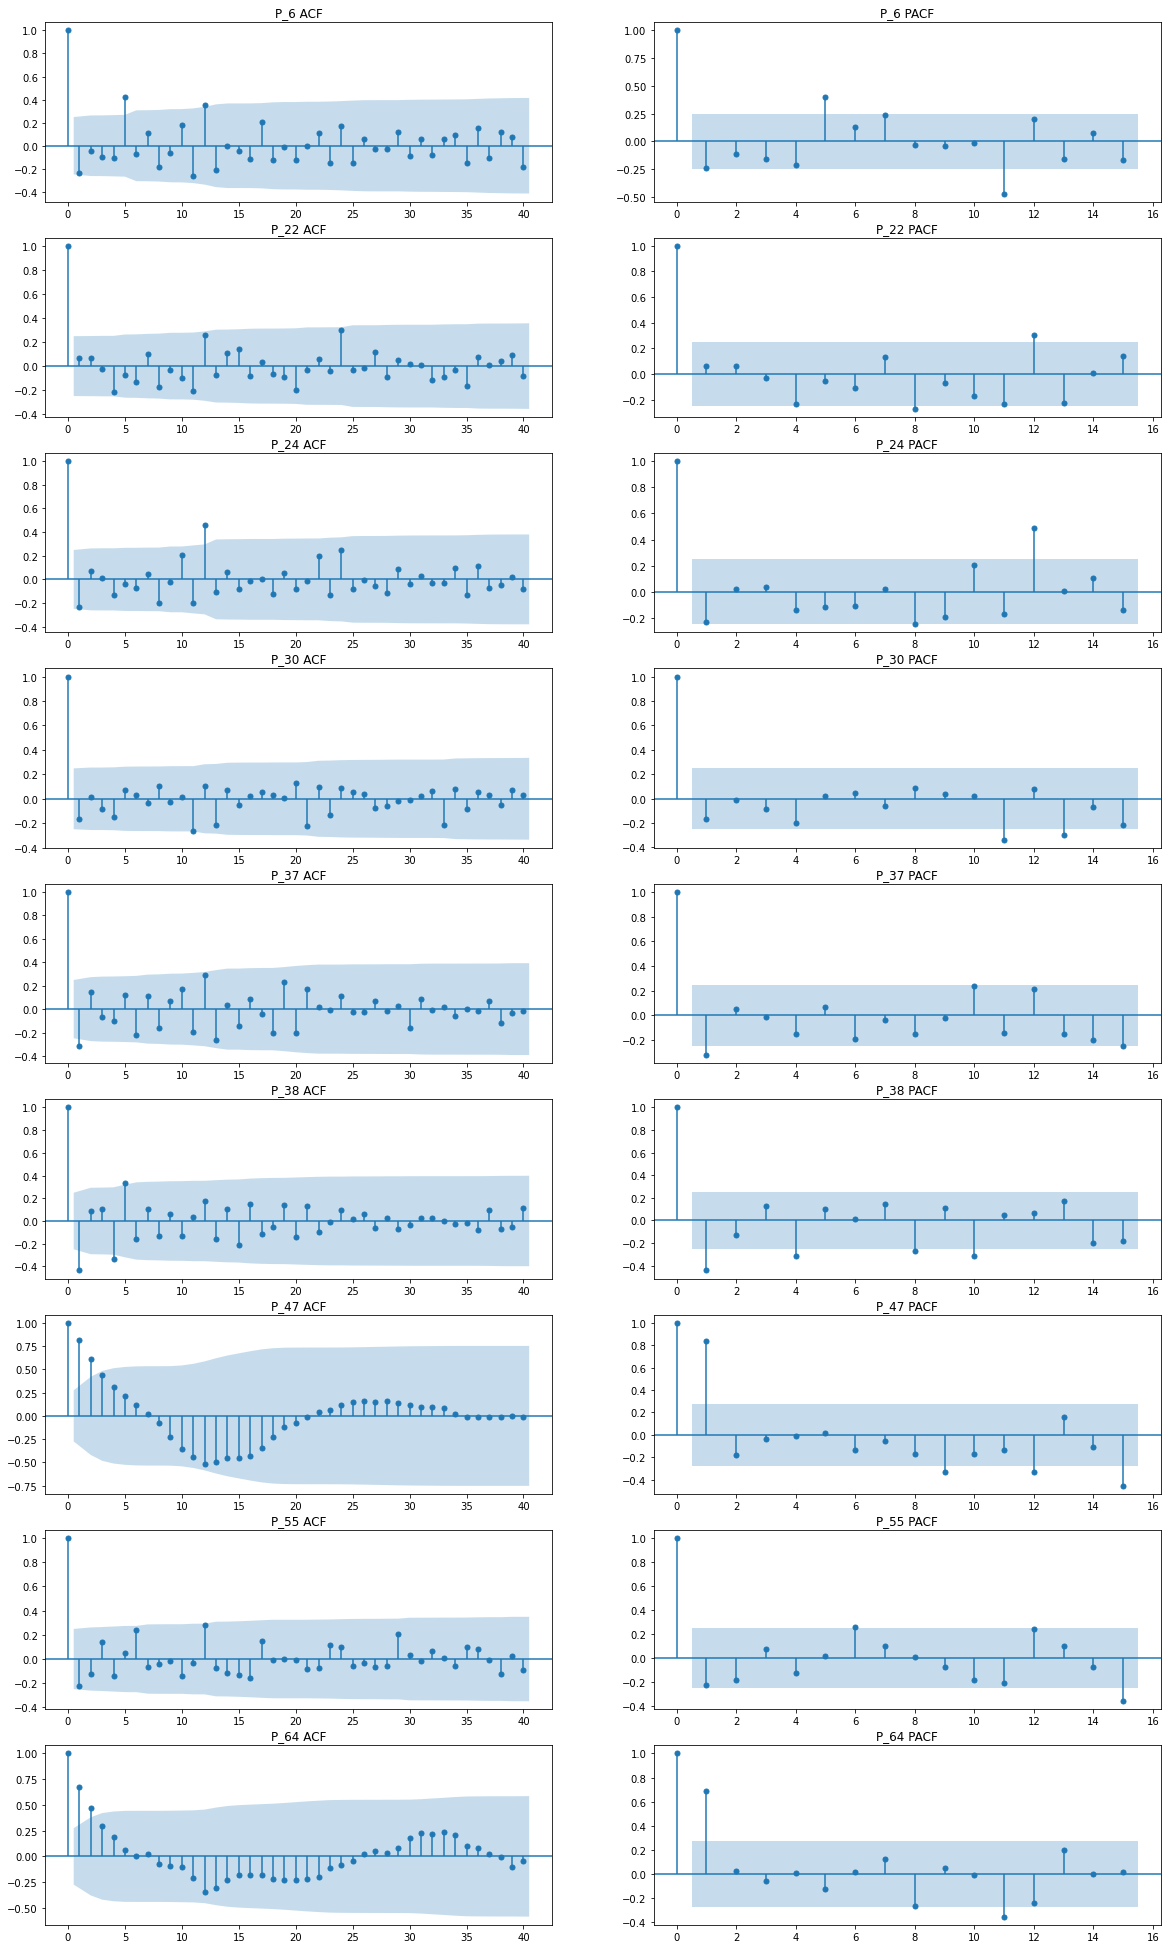

In [16]:
fig, axes = plt.subplots(9, 2, figsize=(20, 35), sharex=False)
alpha=.05
for i, col in enumerate(sales_s.columns):
    sm.graphics.tsa.plot_acf(stationnaries[col].dropna().values.squeeze(), lags=40, \
                             ax=axes[i,0], title=f"{col} ACF", alpha=alpha)
    sm.graphics.tsa.plot_pacf(stationnaries[col].dropna().values.squeeze(), lags=15, \
                              ax=axes[i,1], title=f"{col} PACF", alpha=alpha)

In [18]:
def auto_arima_for_df(df, trace: bool):
    """find best arima model for each series in a data frame, returns dict of models"""
    # models = [0]*len(df.columns)
    models = {}
    for col in df.columns:
        if trace : print('\n',col, ':')
        models[col] = pm.auto_arima(df[col], start_p=1, start_q=1,
                              test='adf',       # use adftest to find optimal 'd'
                              max_p=3, max_q=3, # maximum p and q
                              m=12,              # frequency of series
        #                       d=None,           # let model determine 'd'
        #                       seasonal=True,   # No Seasonality
        #                       start_P=0, 
        #                       D=0, 
                              trace=trace,
        #                       error_action='ignore',  
        #                       suppress_warnings=True, 
                              stepwise=True)
    return models

In [21]:
joblib_Filename = "joblib_ARIMA_sales_s_Models.joblib"
# if compress: joblib_Filename += '.z'
try:
    models = joblib.load(joblib_Filename)
    print("models imported")
except FileNotFoundError:
    models = auto_arima_for_df(sales_s, trace=False) #fitting the model
    joblib.dump(models, joblib_Filename)
    print("models created and exported")

models imported


In [22]:
res = pd.DataFrame(columns=['Best model', 'AIC','BIC'])
for col in sales_s.columns:
    tbl = models[col].summary().tables[0].data
    res = res.append({"Best model": tbl[1][1], \
                      "AIC": float(tbl[2][3]),\
                      "BIC": float(tbl[3][3])}\
                     ,ignore_index=True)
res.set_index(sales_s.columns)

,Best model,AIC,BIC
P_6,"SARIMAX(0, 1, 0)x(1, 0, 0, 12)",902.923,907.177
P_22,"SARIMAX(0, 1, 0)",1063.119,1065.246
P_24,"SARIMAX(0, 1, 1)x(1, 0, [], 12)",1010.217,1016.599
P_30,"SARIMAX(0, 1, 0)",1109.946,1112.074
P_37,"SARIMAX(1, 1, 0)x(1, 0, 0, 12)",829.734,836.116
P_38,"SARIMAX(2, 1, 1)x(2, 0, [], 12)",881.211,893.974
P_47,"SARIMAX(0, 1, 0)x(1, 1, 0, 12)",566.959,570.783
P_55,"SARIMAX(0, 1, 1)x(1, 0, [], 12)",964.691,971.072
P_64,"SARIMAX(0, 1, 0)x(0, 1, [1], 12)",581.183,585.007


$
\begin{align}
P_{6} : (1 - \Phi_1  B^{12}) (1 - B) y_t = e_t \\
P_{22} : (1 - B) y_t = e_t \\
P_{24} : (1 - \Phi_1  B^{12}) (1 - B) y_t = (1 + \theta_1 B) e_t \\
P_{30} : (1 - B) y_t = e_t \\
P_{37} : (1 - \phi_1 B) (1 - \Phi_1  B^{12}) (1 - B) y_t = e_t \\
P_{38} : (1 - \phi_1 B - \phi_2 B^2) (1 - \Phi_1  B^{12} - \Phi_2  B^{24}) (1 - B) y_t = (1 + \theta_1 B) e_t \\
P_{47} : (1 - \phi_1  B^{12}) (1 - B) (1 - B^{12}) y_t = e_t \\
P_{55} : (1 - \phi_1  B^{12}) (1 - B) y_t = (1 + \theta_1 B) e_t \\
P_{64} : (1 - B) (1 - B^{12}) y_t = (1 + \Theta_1 B^{12}) e_t \\
\end{align}
$

On a effectué la prévision de l'ensemble des séries par les meilleurs modèles ARIMA séléctionnés selon deux approches.

La méthode de prévision statique calcule une séquence de prévisions à un pas d'avance, en utilisant les valeurs réelles plutôt que prévues pour les variables dépendantes décalées, si elles sont disponibles. En effet, pour effectuer la prévision d'un nouveau mois, le modèle est mis a jour en incluant la valeur réelle du mois précédant, cette méthode est plus performante et donne des prévisions moins biaisées mais ne peut etre utilisée que pour prévoir un seul mois à l'avance. 

La méthode de prévision dynamique calcule des prévisions dynamiques en plusieurs étapes à partir de la première période de l'échantillon de prévision, les valeurs précedemment prévues pour les variables dépendantes décalées sont utilisées pour former la prévision de la valeur actuelle. Cette méthode est utile lorsque l'entreprise s'interesse à effectuer une prévision à long terme, c'est dire prévoir les ventes de plusieurs mois à l'avance.

Les graphiques ci-dessous représentent les prévisions effectuées par les deux méthodes ainsi que les intervalles de confiance (95%).
On peut constater que les séries des deux produits P_22 et P_30 correspondent à des marches aléatoires, la meilleure prévision dans ce cas est la valeur précendente.
Les intervalles de prévision associés à la méthode dynamique s'allongent à mesure que l'horizon de prévision s'allonge, plus nous prévoyons à l'avance, plus l'incertitude est associée à la prévision, et donc plus les intervalles de prévision sont larges.
Dans les prévisions par la méthode statique, la variation de la distribution des prévisions est presque la même que la variation des résidus.

Must read : \
https://www.kddanalytics.com/practical-time-series-forecasting-deterministic-stochastic-trend-2/ \
https://otexts.com/fpp2/stochastic-and-deterministic-trends.html \
http://alkaline-ml.com/pmdarima/tips_and_tricks.html

In [23]:
train_arima = sales_s.loc[:'2018-12-31']
test_arima = sales_s.loc['2019-01-31':]

In [24]:
def empty_df_like(df):
    return pd.DataFrame(columns=df.columns, index= df.index)
def empty_df_to_date(df, n_periods):
    return pd.DataFrame(columns=df.columns, \
                        index= pd.date_range(df.index[-1], freq="M", periods=n_periods).shift(1, freq='M'))

In [25]:
def arima_dynamic_out_of_sample_forecast(models, train_df, n_periods) :
    """enerate future dynamic forecast to the given periods"""
    # fitted_dynamic = [0]*len(train_df.columns)
    fc_df = empty_df_to_date(train_df, n_periods)
    lower_df = empty_df_to_date(train_df, n_periods)
    upper_df = empty_df_to_date(train_df, n_periods)
    
    for  col in train_df.columns:
        fitted_dynamic = models[col].fit(train_df[col])
        fc, confint = fitted_dynamic.predict(n_periods= n_periods, return_conf_int=True)
        
        fc_df[col] = fc
        lower_df[col] = confint[:, 0]
        upper_df[col] = confint[:, 1]
    return {'fc_df' : fc_df, 'lower_df' : lower_df, 'upper_df' : upper_df}

In [26]:
def arima_dynamic_in_sample_forecast(models, train_df, test_df) :
    """generate dynamic forecast with confidence intervales and accuracy"""
    n_series=len(train_df.columns)
    n_periods = len(test_df)
    # fitted_dynamic = [0]*n_series
    accuracies_dynamic = pd.DataFrame(columns=test_df.columns, index=['mape', 'mae', 'rmse','mape_exces','mape_short'])
    
    fc_df = empty_df_like(test_df)
    lower_df = empty_df_like(test_df)
    upper_df = empty_df_like(test_df)
    
    for col in train_df.columns:
        fitted_dynamic = models[col].fit(train_df[col])
        fc, confint = fitted_dynamic.predict(n_periods= n_periods, return_conf_int=True)

        fc_df[col] = fc
        lower_df[col] = confint[:, 0]
        upper_df[col] = confint[:, 1]
        accuracies_dynamic[col] = forecast_accuracy(fc_df[col], test_df[col])
    return {'fc_df' : fc_df, 'lower_df' : lower_df, 'upper_df' : upper_df, 'accuracies_dynamic' : accuracies_dynamic}

In [27]:
def plot_forecast(forecast_data, df, plot_anomalies=False):
    n_series = len(df.columns)
    fig_n_lines = ceil(n_series/2)
    # fig, axs = plt.subplots(fig_n_lines, 2 if n_series>1 else 1, figsize=(20, fig_n_lines*4))
    if n_series>1 : 
        fig, axs = plt.subplots(fig_n_lines, 2, figsize=(20, fig_n_lines*4))
        remove_axes(n_series, axs)
        axs = axs.flatten()
    else :
        fig, axs = plt.subplots(fig_n_lines, 1, figsize=(15, 7))
        axs = [axs]

    for i, item in enumerate(df.columns):
        axs[i].plot(df[item], label="actual")
        # axs[i].plot(pd.concat([df[item], forecast_data['fc_df'][item]]), label="actual")
        axs[i].plot(forecast_data['fc_df'][item], color='darkgreen', label="forecast")
        axs[i].set_title(f"{item} forecast")

        lower = forecast_data['lower_df'][item]
        upper = forecast_data['upper_df'][item]
        axs[i].plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        axs[i].plot(upper, "r--", alpha=0.5)
        
        axs[i].axvspan(lower.index[0], lower.index[-1],  color=sns.xkcd_rgb['grey'], alpha=0.2)

        
        if plot_anomalies:
            index_of_pred = forecast_data['fc_df'].index
            y_test = df[item][index_of_pred]
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            anomalies_series = pd.Series(anomalies, index=index_of_pred)
            if ~np.isnan(anomalies).all() : axs[i].plot(anomalies_series, "o", markersize=10, label = "Anomalies")
        axs[i].legend(loc="best")


In [38]:
arima_dynamic_in_sample_forecast_res=arima_dynamic_in_sample_forecast(models, train_arima, test_arima)
# arima_dynamic_in_sample_forecast_res
pretty_df(arima_dynamic_in_sample_forecast_res['accuracies_dynamic'])

Series,P_6,P_22,P_24,P_30,P_37,P_38,P_47,P_55,P_64
mape,11.187287,6.166482,6.036564,5.999308,5.759123,5.542042,8.716832,9.811062,6.667103
mae,303.176930,1156.888889,624.455877,1214.777778,215.024574,222.121861,73.988869,746.358974,105.540172
rmse,153842.936984,1440781.555556,653278.202649,2184788.111111,65971.833832,101129.038650,7228.032853,974406.058422,14501.115178
mape_exces,79.520694,32.220680,70.026226,27.370023,36.400725,96.274897,90.898348,97.929182,96.897703
mape_short,20.479306,67.779320,29.973774,72.629977,63.599275,3.725103,9.101652,2.070818,3.102297


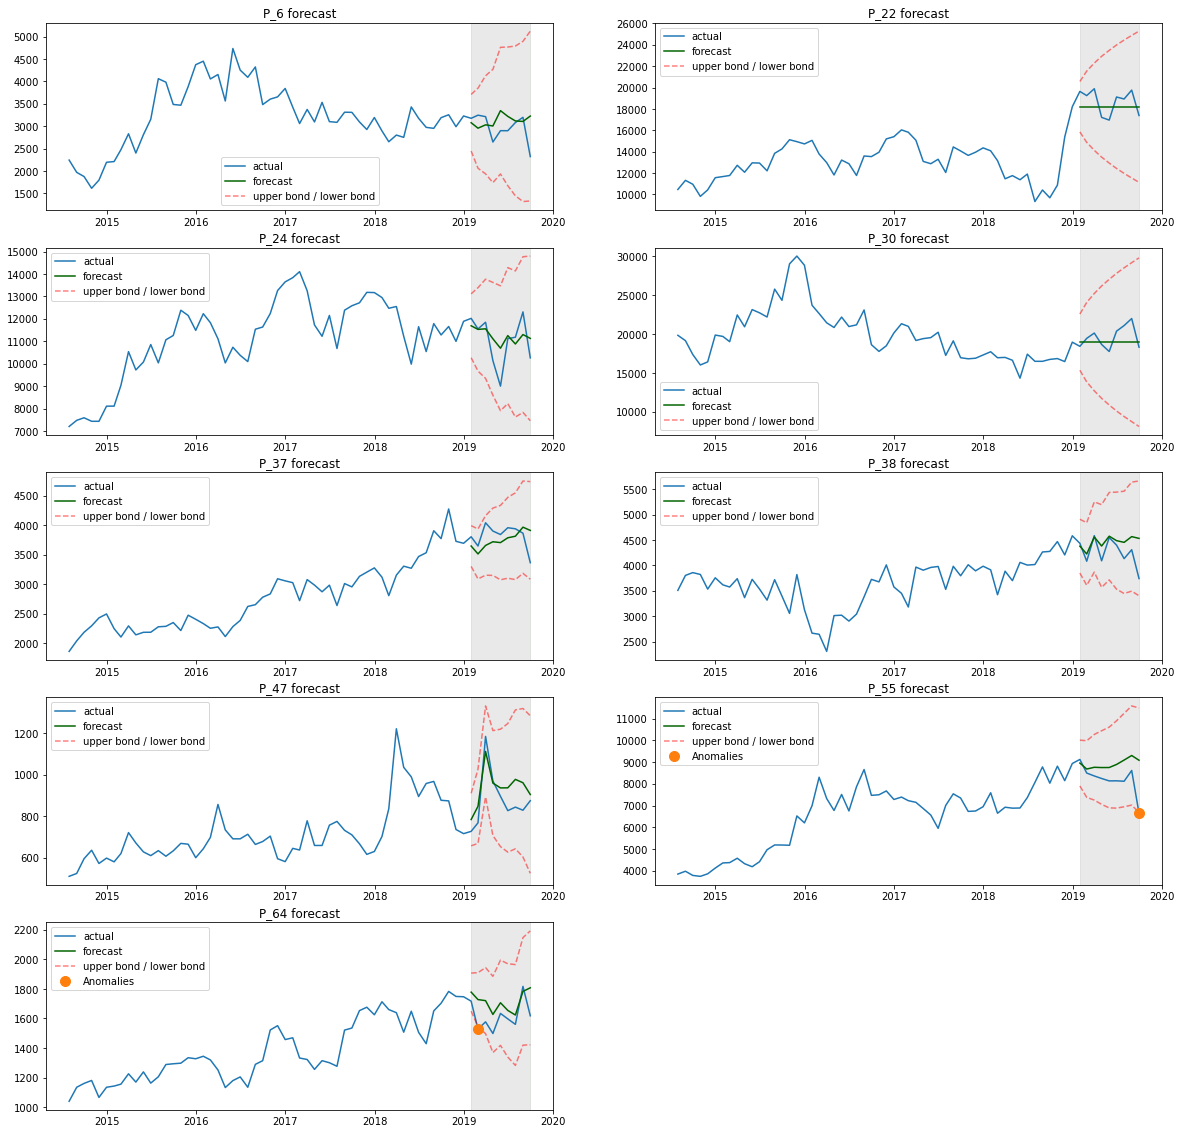

In [29]:
plot_forecast(arima_dynamic_in_sample_forecast_res, sales_s,True)

In [30]:
arima_dynamic_out_of_sample_forecast_res=arima_dynamic_out_of_sample_forecast(models, sales_s, 12)
# arima_dynamic_out_of_sample_forecast_res


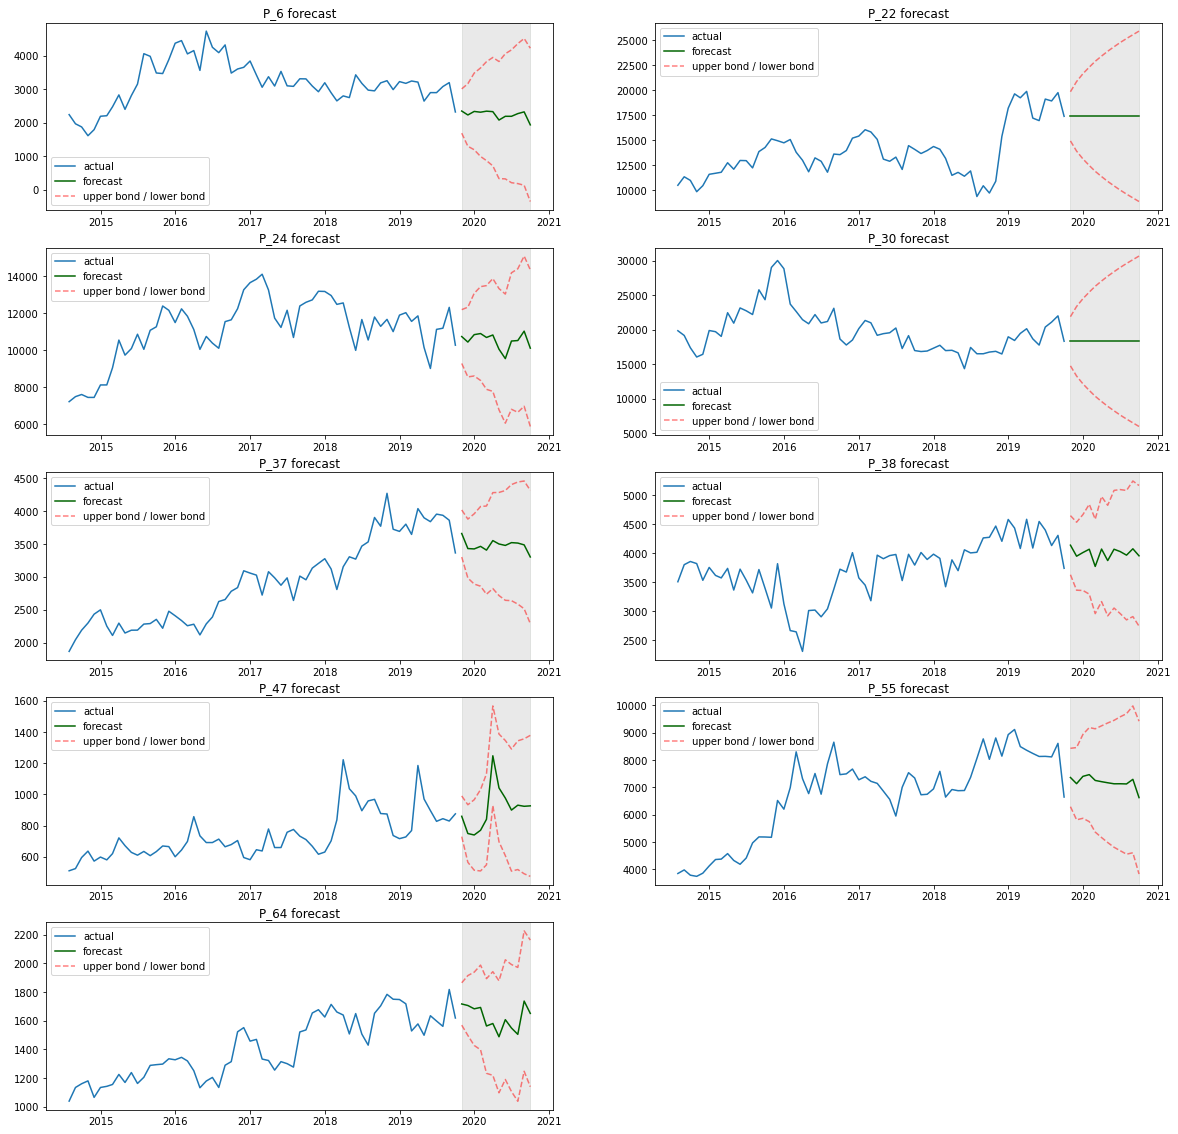

In [31]:
plot_forecast(arima_dynamic_out_of_sample_forecast_res, sales_s)

In [32]:
def arima_static_in_sample_forecast(models, train_df, test_df) :
    """generate dynamic forecast with confidence intervales and accuracy"""
    n_series=len(train_df.columns)
    n_periods = len(test_df)
    # fitted_static = [0]*n_series
    accuracies_static = pd.DataFrame(columns=test_df.columns, index=['mape', 'mae', 'rmse','mape_exces','mape_short'])
    
    fc_df = empty_df_like(test_df)
    lower_df = empty_df_like(test_df)
    upper_df = empty_df_like(test_df)
    
    for col in train_df.columns:
        fitted_static = models[col].fit(train_df[col])
        preds =np.zeros((len(test_df)))
        conf_int = np.zeros((len(test_df),2))

        for j in range(len(test_df)):
            new_preds, new_conf_int = fitted_static.predict(n_periods=1, return_conf_int=True)
            fitted_static.update([test_df[col].iloc[j]])
            preds[j] = new_preds
            conf_int[j] = new_conf_int

        fc_df[col] = preds
        lower_df[col] = conf_int[:, 0]
        upper_df[col] = conf_int[:, 1]
        accuracies_static[col] = forecast_accuracy(fc_df[col], test_df[col])
    return {'fc_df' : fc_df, 'lower_df' : lower_df, 'upper_df' : upper_df, 'accuracies_static' : accuracies_static}

In [39]:
arima_static_in_sample_forecast_res=arima_static_in_sample_forecast(models, train_arima, test_arima)
pretty_df(arima_static_in_sample_forecast_res['accuracies_static'])

Series,P_6,P_22,P_24,P_30,P_37,P_38,P_47,P_55,P_64
mape,10.622725,6.642814,7.781594,7.220782,4.425410,4.214090,6.252274,5.196195,4.623019
mae,282.464906,1217.111111,827.064471,1393.555556,163.513238,173.036548,57.878158,386.609802,75.191947
rmse,160750.232427,2322438.000000,924051.837534,2951031.555556,48702.964300,43181.137813,5392.836057,363277.664755,10311.821486
mape_exces,72.443266,56.453425,58.174497,55.367526,71.799478,81.532549,52.711708,90.776528,65.664289
mape_short,27.556734,43.546575,41.825503,44.632474,28.200522,18.467451,47.288292,9.223472,34.335711


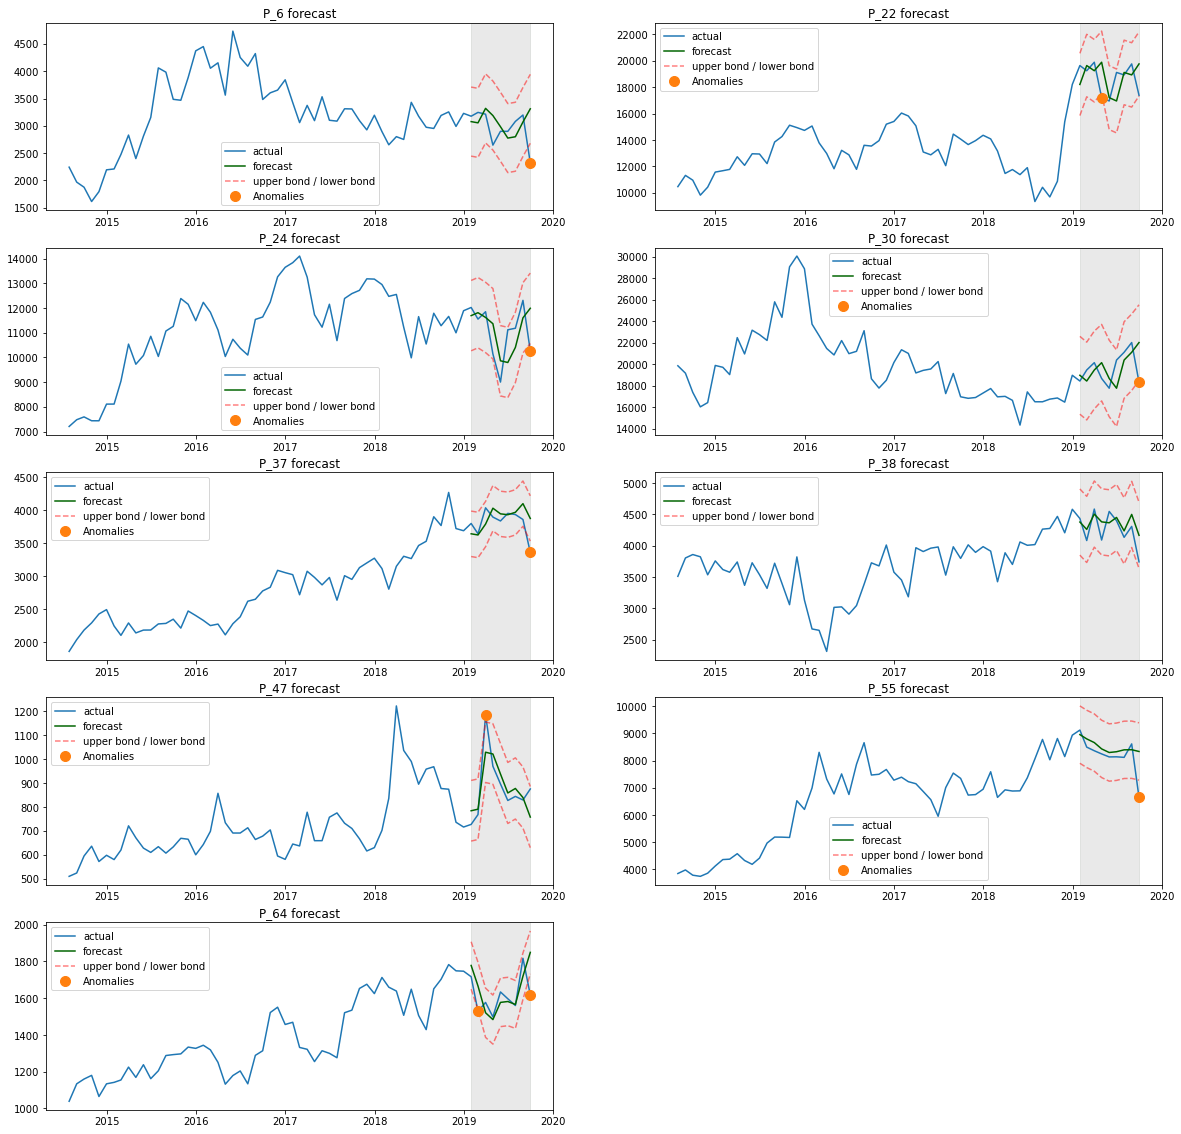

In [34]:
plot_forecast(arima_static_in_sample_forecast_res, sales_s,True)

Ljung-Box (Q) : \
    H0: The residuals are independently distributed.\
    H1: The residuals are not independently distributed; they exhibit serial correlation.\
    Prob(Q)<0.05   =>   the residuals are not independent


Heteroskedasticity (H):\
    H0: The null hypothesis is of no heteroskedasticity.\
    H1: heteroskedasticity.\
    Prob(H)<0.05   =>   heteroskedasticity.


Jarque-Bera (JB):\
    H0: Normality\
    H1: No normality\
    Prob(H)<0.05   =>   no normality

Pour la validation des modèles obtenus, on a effectué un diagnostic des résidus.
le tableau ci-dessous synthétise les résultats des tests de bruit blanc, homoscedasticité et normalité pour le résidus de chacune des séries

In [35]:
def Verif(x):
    return "Vérifié" if x else "Non Vérifié" 

In [36]:
res = pd.DataFrame(columns=['Prob(Q)', 'White noise', 'Prob(H)','Homoscedasticity','Prob(JB)','Normality'])
for col in sales_s.columns:
    tbl = models[col].summary().tables[2].data
    res = res.append({"Prob(Q)": float(tbl[1][1]), "White noise": Verif(float(tbl[1][1])>0.05), \
                      "Prob(H)": float(tbl[3][1]), "Homoscedasticity": Verif(float(tbl[3][1])>0.05), \
                      "Prob(JB)": float(tbl[1][3]), "Normality": Verif(float(tbl[1][3])>0.05)}\
                     ,ignore_index=True)
res.set_index(sales_s.columns)


,Prob(Q),White noise,Prob(H),Homoscedasticity,Prob(JB),Normality
P_6,0.43,Vérifié,0.73,Vérifié,0.29,Vérifié
P_22,0.60,Vérifié,0.00,Non Vérifié,0.01,Non Vérifié
P_24,0.60,Vérifié,0.65,Vérifié,0.34,Vérifié
P_30,0.18,Vérifié,0.09,Vérifié,0.50,Vérifié
P_37,1.00,Vérifié,0.00,Non Vérifié,0.06,Vérifié
P_38,0.74,Vérifié,0.02,Non Vérifié,0.49,Vérifié
P_47,0.89,Vérifié,0.10,Vérifié,0.00,Non Vérifié
P_55,0.68,Vérifié,0.71,Vérifié,0.40,Vérifié
P_64,0.27,Vérifié,0.69,Vérifié,0.28,Vérifié


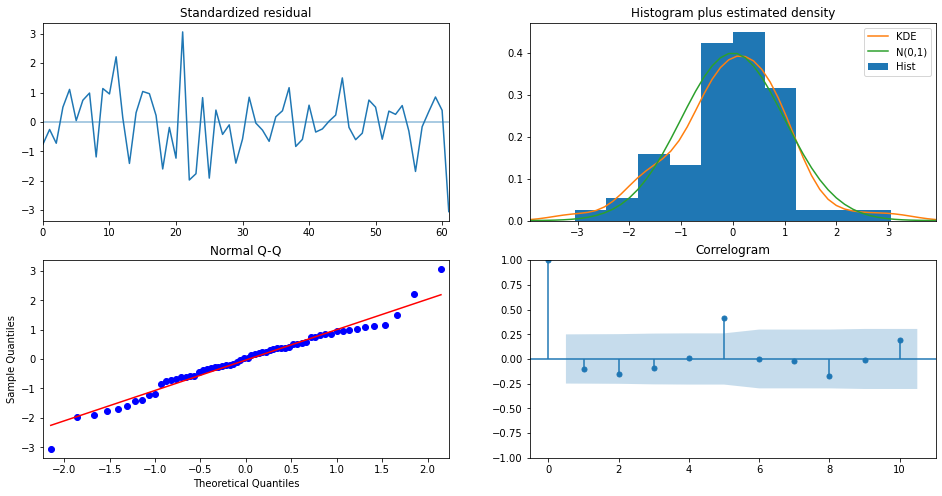

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   63
Model:             SARIMAX(0, 1, 0)x(1, 0, 0, 12)   Log Likelihood                -449.587
Date:                            Fri, 30 Jul 2021   AIC                            903.174
Time:                                    18:08:30   BIC                            907.428
Sample:                                         0   HQIC                           904.845
                                             - 63                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.4503      0.101      4.460      0.000       0.252       0.648
sigma2      1.036e+05   1.42e+04      7.299      0.000    7.58e+04    1.31e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.62   Jarque-Bera (JB):                 2.49
Prob(Q):                              0.43   Prob(JB):                         0.29
Heteroskedasticity (H):               0.86   Skew:                            -0.12
Prob(H) (two-sided):                  0.73   Kurtosis:                         3.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

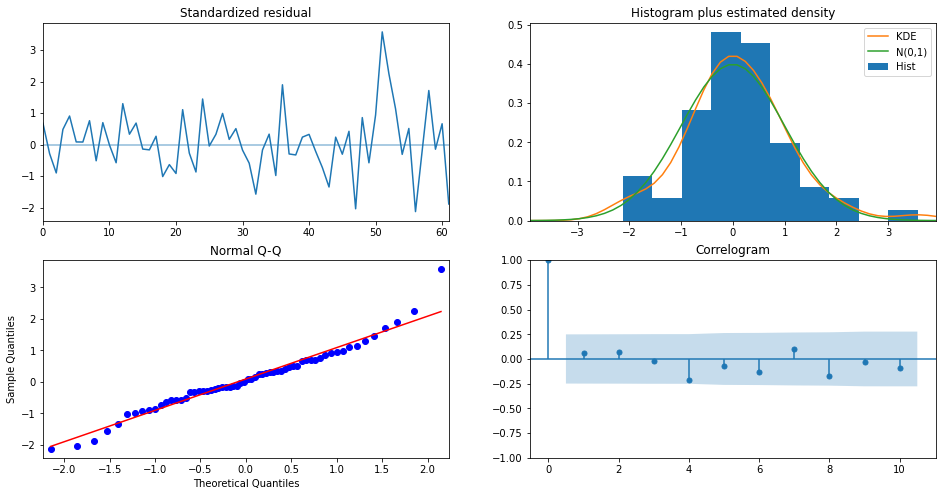

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   63
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -530.559
Date:                Fri, 30 Jul 2021   AIC                           1063.119
Time:                        18:08:31   BIC                           1065.246
Sample:                             0   HQIC                          1063.954
                                 - 63                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.585e+06    2.1e+05      7.558      0.000    1.17e+06       2e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.28   Jarque-Bera (JB):                 8.43
Prob(Q):                              0.60   Prob(JB):                         0.01
Heteroskedasticity (H):               4.56   Skew:                             0.48
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

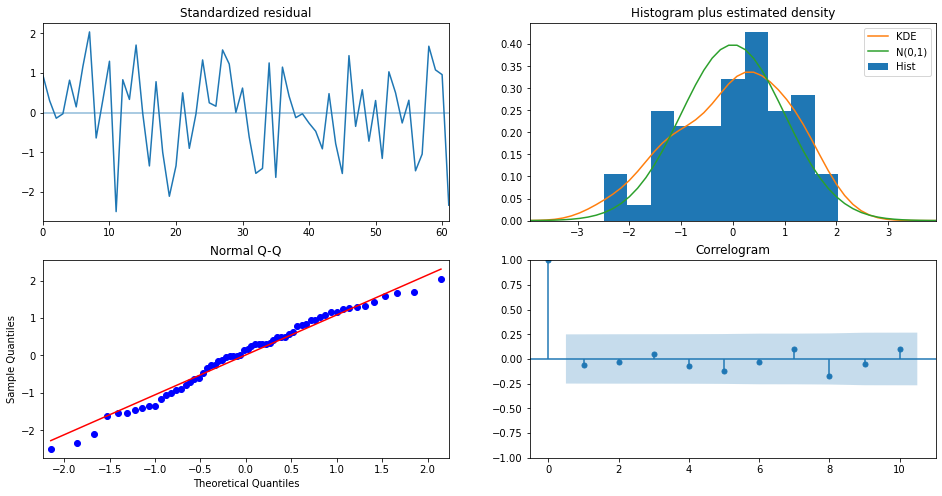

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   63
Model:             SARIMAX(0, 1, 1)x(1, 0, [], 12)   Log Likelihood                -502.138
Date:                             Fri, 30 Jul 2021   AIC                           1010.275
Time:                                     18:08:33   BIC                           1016.657
Sample:                                          0   HQIC                          1012.781
                                              - 63                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1770      0.097     -1.834      0.067      -0.366       0.012
ar.S.L12       0.4572      0.073      6.284      0.000       0.315       0.600
sigma2       5.28e+05   1.15e+05      4.610      0.000    3.04e+05    7.52e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.28   Jarque-Bera (JB):                 2.17
Prob(Q):                              0.60   Prob(JB):                         0.34
Heteroskedasticity (H):               0.82   Skew:                            -0.35
Prob(H) (two-sided):                  0.65   Kurtosis:                         2.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

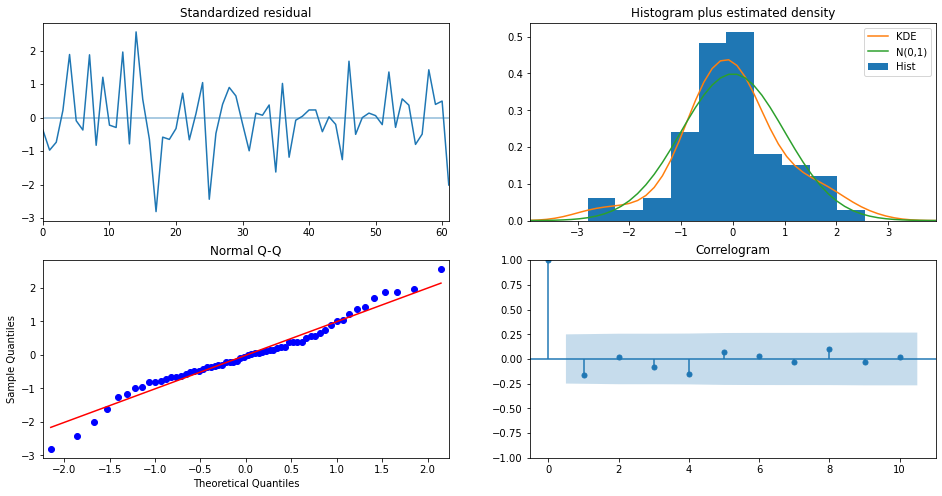

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   63
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -553.969
Date:                Fri, 30 Jul 2021   AIC                           1109.939
Time:                        18:08:35   BIC                           1112.066
Sample:                             0   HQIC                          1110.774
                                 - 63                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      3.366e+06   5.16e+05      6.519      0.000    2.35e+06    4.38e+06
===================================================================================
Ljung-Box (L1) (Q):                   1.76   Jarque-Bera (JB):                 1.37
Prob(Q):                              0.18   Prob(JB):                         0.50
Heteroskedasticity (H):               0.47   Skew:                            -0.03
Prob(H) (two-sided):                  0.09   Kurtosis:                         3.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

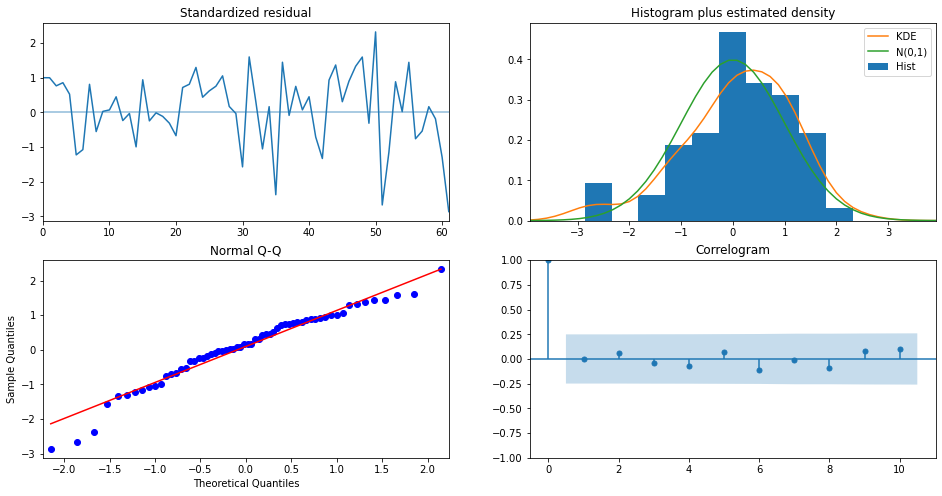

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   63
Model:             SARIMAX(1, 1, 0)x(1, 0, 0, 12)   Log Likelihood                -411.987
Date:                            Fri, 30 Jul 2021   AIC                            829.975
Time:                                    18:08:37   BIC                            836.356
Sample:                                         0   HQIC                           832.480
                                             - 63                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2460      0.097     -2.542      0.011      -0.436      -0.056
ar.S.L12       0.3784      0.126      2.997      0.003       0.131       0.626
sigma2      3.064e+04   4852.945      6.314      0.000    2.11e+04    4.02e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 5.49
Prob(Q):                              1.00   Prob(JB):                         0.06
Heteroskedasticity (H):               3.79   Skew:                            -0.69
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

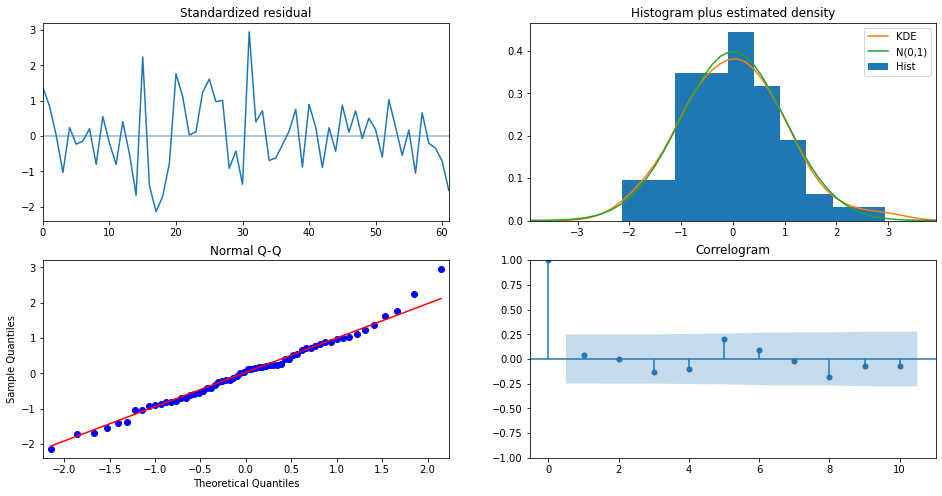

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   63
Model:             SARIMAX(2, 1, 1)x(2, 0, [], 12)   Log Likelihood                -434.691
Date:                             Fri, 30 Jul 2021   AIC                            881.382
Time:                                     18:08:39   BIC                            894.145
Sample:                                          0   HQIC                           886.393
                                              - 63                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3197      0.165     -8.018      0.000      -1.642      -0.997
ar.L2         -0.5661      0.111     -5.101      0.000      -0.784      -0.349
ma.L1          0.8918      0.140      6.364      0.000       0.617       1.166
ar.S.L12       0.1837      0.172      1.071      0.284      -0.153       0.520
ar.S.L24       0.2227      0.250      0.890      0.373      -0.267       0.713
sigma2      7.281e+04   1.49e+04      4.873      0.000    4.35e+04    1.02e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                 1.42
Prob(Q):                              0.74   Prob(JB):                         0.49
Heteroskedasticity (H):               0.34   Skew:                             0.33
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

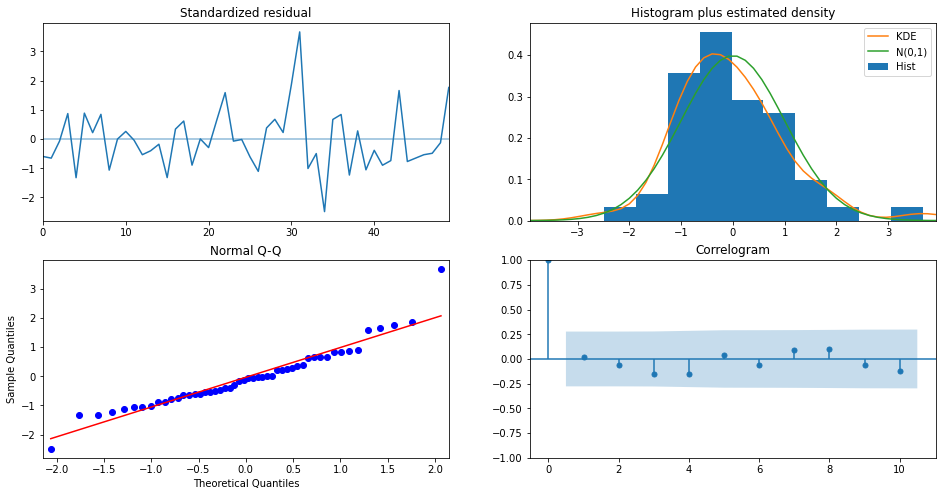

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   63
Model:             SARIMAX(0, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -281.499
Date:                            Fri, 30 Jul 2021   AIC                            566.999
Time:                                    18:08:41   BIC                            570.823
Sample:                                         0   HQIC                           568.455
                                             - 63                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.3158      0.122     -2.595      0.009      -0.554      -0.077
sigma2      4258.8318    593.645      7.174      0.000    3095.310    5422.354
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                17.03
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               2.29   Skew:                             0.92
Prob(H) (two-sided):                  0.10   Kurtosis:                         5.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

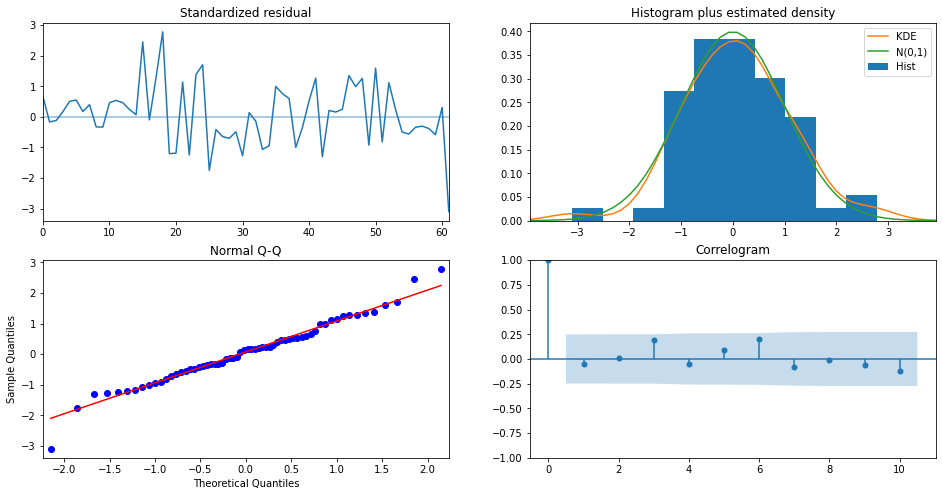

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   63
Model:             SARIMAX(0, 1, 1)x(1, 0, [], 12)   Log Likelihood                -479.358
Date:                             Fri, 30 Jul 2021   AIC                            964.717
Time:                                     18:08:43   BIC                            971.098
Sample:                                          0   HQIC                           967.222
                                              - 63                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2705      0.117     -2.306      0.021      -0.500      -0.041
ar.S.L12       0.3422      0.142      2.418      0.016       0.065       0.620
sigma2      2.886e+05   4.51e+04      6.399      0.000       2e+05    3.77e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):                 1.83
Prob(Q):                              0.68   Prob(JB):                         0.40
Heteroskedasticity (H):               1.18   Skew:                            -0.02
Prob(H) (two-sided):                  0.71   Kurtosis:                         3.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

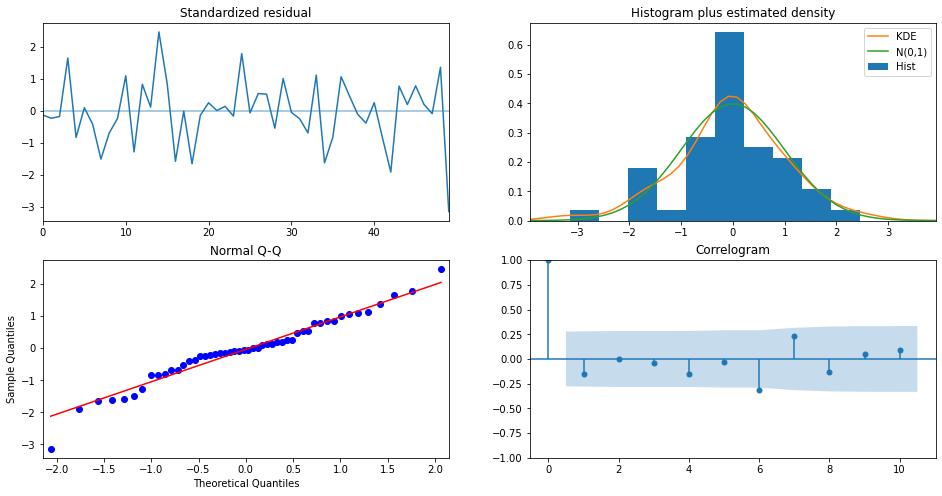

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   63
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -290.064
Date:                              Fri, 30 Jul 2021   AIC                            584.127
Time:                                      18:08:45   BIC                            587.951
Sample:                                           0   HQIC                           585.583
                                               - 63                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.9753      3.317     -0.294      0.769      -7.477       5.526
sigma2      4323.8951   1.37e+04      0.314      0.753   -2.26e+04    3.13e+04
===================================================================================
Ljung-Box (L1) (Q):                   1.23   Jarque-Bera (JB):                 2.57
Prob(Q):                              0.27   Prob(JB):                         0.28
Heteroskedasticity (H):               1.22   Skew:                            -0.34
Prob(H) (two-sided):                  0.69   Kurtosis:                         3.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [37]:
for col in sales_s.columns:
    models[col].plot_diagnostics(figsize=(16,8))
    plt.show()
    display(models[col].summary())